In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
input_vector = 32
img_shape = (1, 28, 28)
batch_size = 128
epochs = 1000
lr = 0.0002
beta1 = 0.5


download the Dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), # transoform [0,255] to [0,1]
    transforms.Normalize([0.5], [0.5]) # [0,1] to [-1,1]
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 409kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.32MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.FC1 = nn.Linear(input_vector, 14 * 14 * 128)

        self.model = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # CORRECTED: Use kernel_size=3 with padding=1 to maintain 14×14
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # This goes from 14×14 to 28×28
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer to get 1 channel
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.FC1(z)
        out = out.view(-1, 128, 14, 14)
        img = self.model(out)
        return img

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):

    super(Discriminator, self).__init__()
    self.model = nn.Sequential(

      #14,14,64
      nn.Conv2d(1,64, kernel_size=4, stride =2, padding=1),
      nn.LeakyReLU(0.2, inplace=True),

      #7,7,128
      nn.Conv2d(64,128, kernel_size=4, stride =2, padding=1),
      nn.LeakyReLU(0.2, inplace=True),

      #
      nn.Conv2d(128,256, kernel_size=4, stride =2, padding=1),
      nn.LeakyReLU(0.2, inplace=True),

    )

    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256*3*3,1),
        nn.Sigmoid()
    )

  def forward(self, img):
    features = self.model(img)
    validity = self.fc(features)
    return validity




In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
print(generator)
print(f"\nNombre de paramètres: {sum(p.numel() for p in generator.parameters() if p.requires_grad)}")


Generator(
  (FC1): Linear(in_features=32, out_features=25088, bias=True)
  (model): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Tanh()
  )
)

Nombre de paramètres: 1107841


In [ ]:
print(discriminator)
print(f"\nNombre de paramètres: {sum(p.numel() for p in discriminator.parameters() if p.requires_grad)}")


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

Nombre de paramètres: 659137


In [ ]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


Training Loop


=== Début de l'entraînement ===
Epoch 10/1000 - D loss: 0.5166, G loss: 1.2770


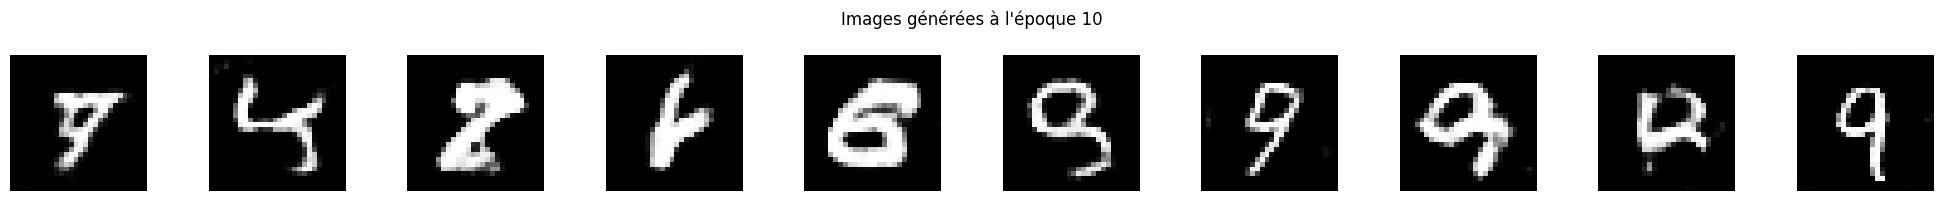

Epoch 20/1000 - D loss: 0.5091, G loss: 1.3154


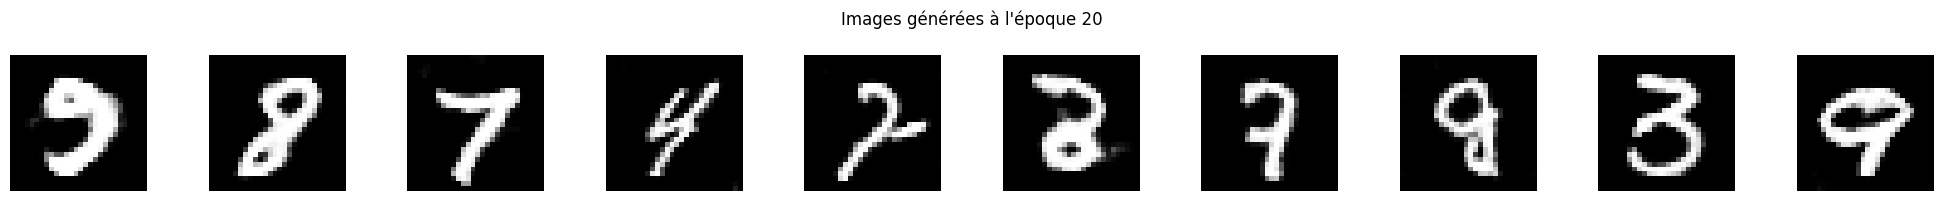

Epoch 30/1000 - D loss: 0.5034, G loss: 1.3553


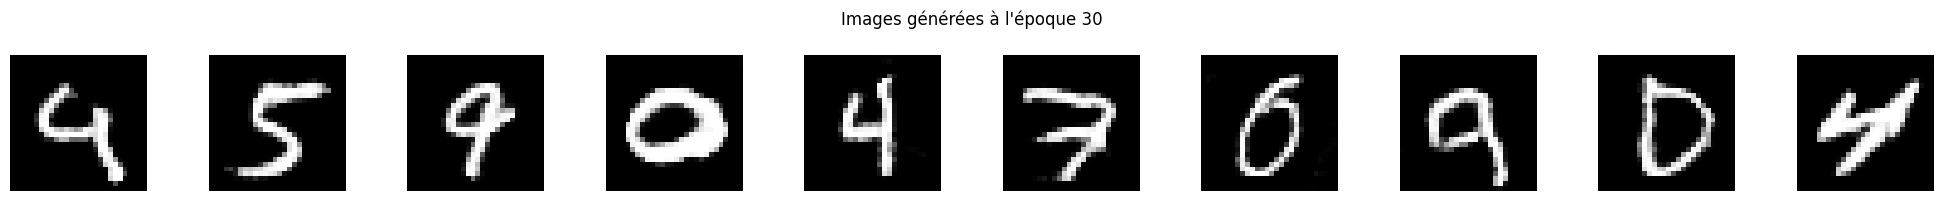

Epoch 40/1000 - D loss: 0.4984, G loss: 1.3674


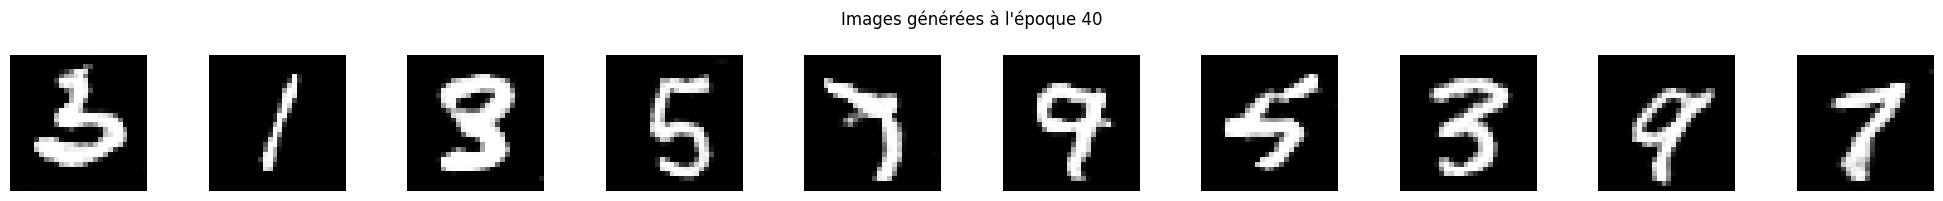

Epoch 50/1000 - D loss: 0.4918, G loss: 1.4154


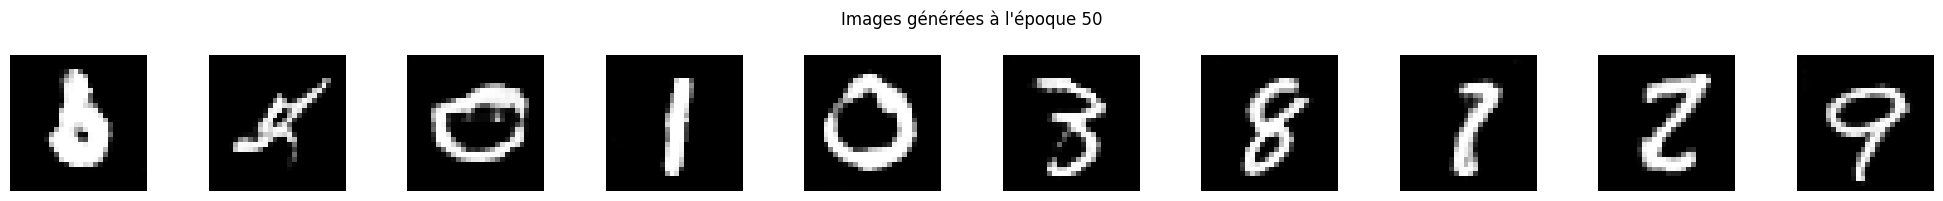

Epoch 60/1000 - D loss: 0.4832, G loss: 1.4440


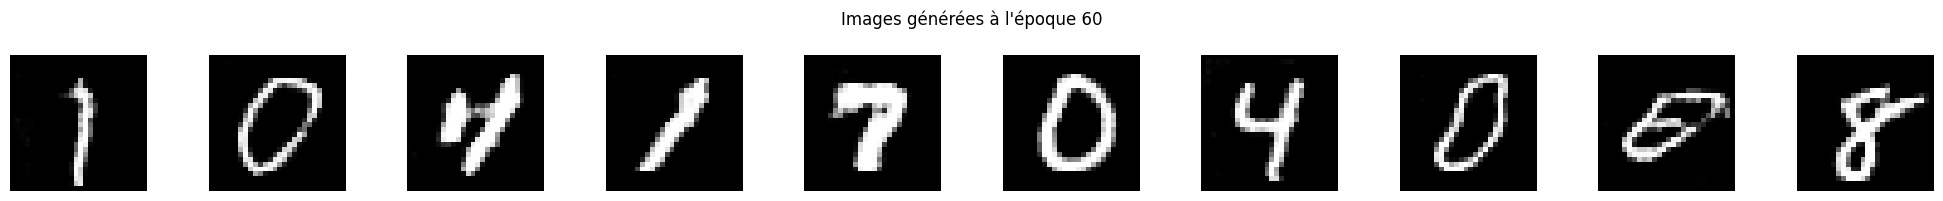

Epoch 70/1000 - D loss: 0.4757, G loss: 1.4757


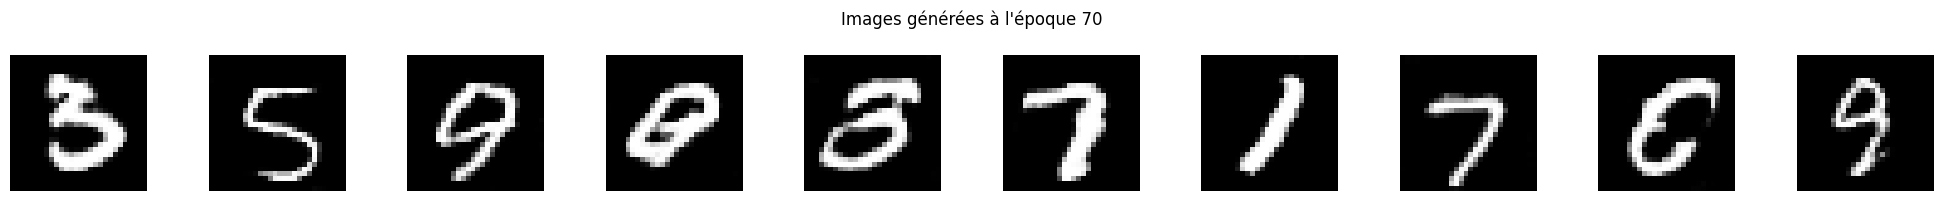

Epoch 80/1000 - D loss: 0.4637, G loss: 1.5266


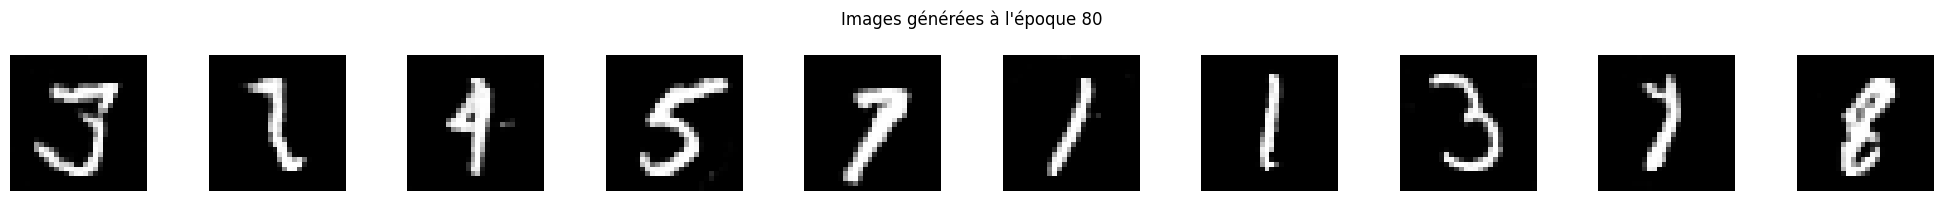

Epoch 90/1000 - D loss: 0.4549, G loss: 1.5710


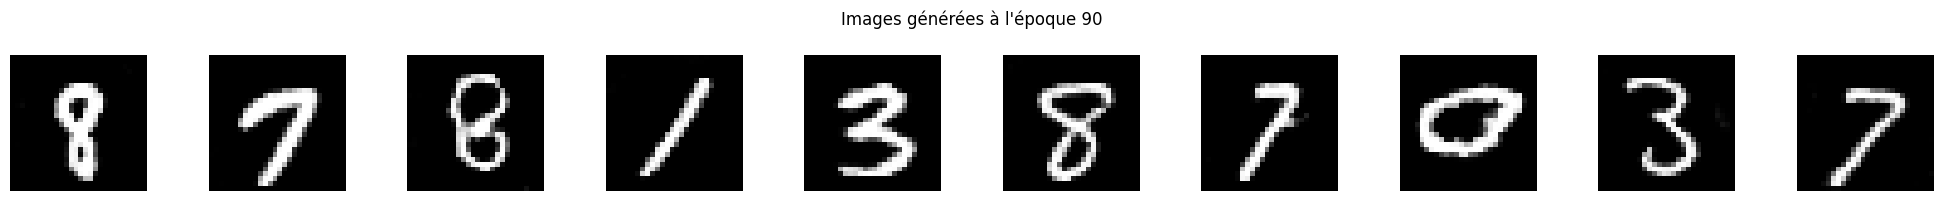

Epoch 100/1000 - D loss: 0.4444, G loss: 1.6224


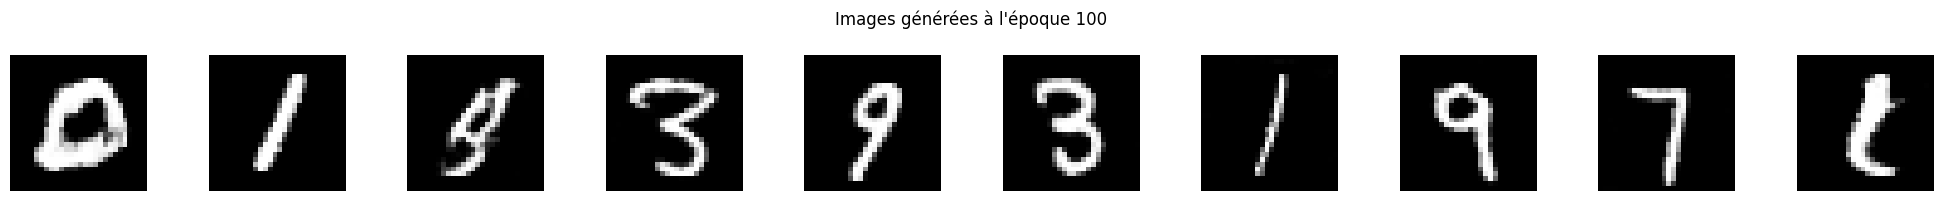

KeyboardInterrupt: 

In [ ]:
def train():
    generator_loss = []
    discriminator_loss = []

    for epoch in range(epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0

        for batch_idx, (real_images, _) in enumerate(train_loader):
            current_batch_size = real_images.size(0)

            # Labels pour les images réelles et fausses
            labels_for_real_images = torch.ones(current_batch_size, 1).to(device)
            labels_for_fake_images = torch.zeros(current_batch_size, 1).to(device)

            real_images = real_images.to(device)

            # 5. Tirage aléatoire du code latent (distribution normale)
            input_noise = torch.randn(current_batch_size, input_vector).to(device)

            # ====== Entraîner le Discriminateur ======
            optimizer_D.zero_grad()

            # 6. Réaliser la prédiction des images générées à partir de G et du code latent
            fake_image = generator(input_noise).detach()  # detach pour ne pas calculer les gradients de G

            # 7. Construire un mélange d'images réelles et d'images générées avec les labels correspondants
            mixed_image = torch.cat([real_images, fake_image])
            mixed_labels = torch.cat([labels_for_real_images, labels_for_fake_images])

            # 8. Entraîner le discriminateur D à partir de ce mélange (équivalent de train_on_batch)
            output = discriminator(mixed_image)
            d_loss = criterion(output, mixed_labels)
            d_loss.backward()
            optimizer_D.step()

            # ====== Entraîner le Générateur (réseau antagoniste) ======
            # 9. Réaliser un nouveau tirage aléatoire du code latent, et créer les labels correspondants à "réel"
            input_noise = torch.randn(current_batch_size, input_vector).to(device)

            # 10. Entraîner le réseau antagoniste (équivalent de train_on_batch)
            optimizer_G.zero_grad()
            fake_images = generator(input_noise)
            output = discriminator(fake_images)
            g_loss = criterion(output, labels_for_real_images)  # Labels "réel" pour tromper D
            g_loss.backward()
            optimizer_G.step()

            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()

        # Moyenne des losses pour l'époque
        avg_d_loss = epoch_d_loss / len(train_loader)
        avg_g_loss = epoch_g_loss / len(train_loader)
        discriminator_loss.append(avg_d_loss)
        generator_loss.append(avg_g_loss)

        # Affichage toutes les 10 époques
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - D loss: {avg_d_loss:.4f}, G loss: {avg_g_loss:.4f}")

            # Tracer 10 images générées
            generator.eval()
            with torch.no_grad():
                noise = torch.randn(10, input_vector).to(device)
                generated_imgs = generator(noise).cpu()
                generated_imgs = (generated_imgs + 1) / 2  # Dénormaliser de [-1, 1] à [0, 1]

            fig, axes = plt.subplots(1, 10, figsize=(20, 2))
            for i in range(10):
                axes[i].imshow(generated_imgs[i, 0], cmap='gray')
                axes[i].axis('off')
            plt.suptitle(f'Images générées à l\'époque {epoch + 1}')
            plt.tight_layout()
            plt.show()

            generator.train()

    # Tracer l'évolution des losses
    plt.figure(figsize=(10, 5))
    plt.plot(discriminator_loss, label='Discriminator Loss')
    plt.plot(generator_loss, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Evolution des losses pendant l\'entraînement')
    plt.grid(True)
    plt.show()

# Lancer l'apprentissage
print("\n=== Début de l'entraînement ===")
train()

Utilisation du device: cuda
=== Architecture du Générateur Conditionnel ===
ConditionalGenerator(
  (fc): Linear(in_features=42, out_features=25088, bias=True)
  (model): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Tanh()
  )
)

Nombre de paramètres: 1358721

=== Architecture du Discriminateur Conditionnel ===
ConditionalDiscriminator(
  (

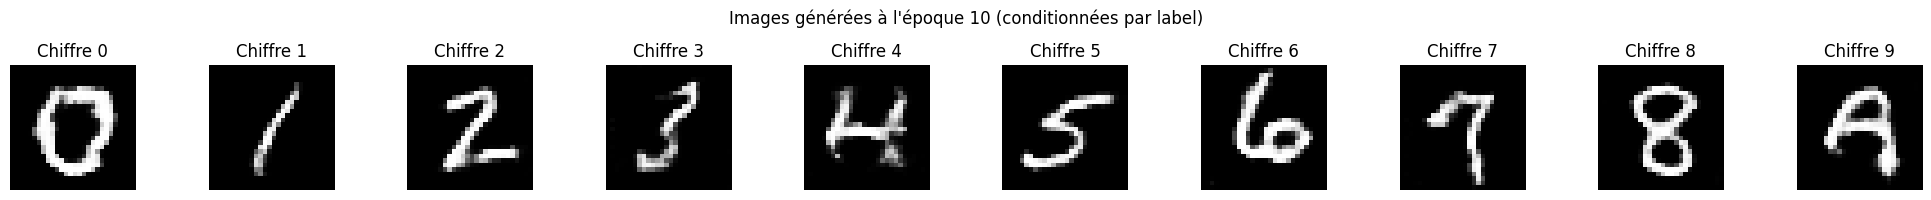

Epoch 20/50 - D loss: 0.6755, G loss: 0.7521


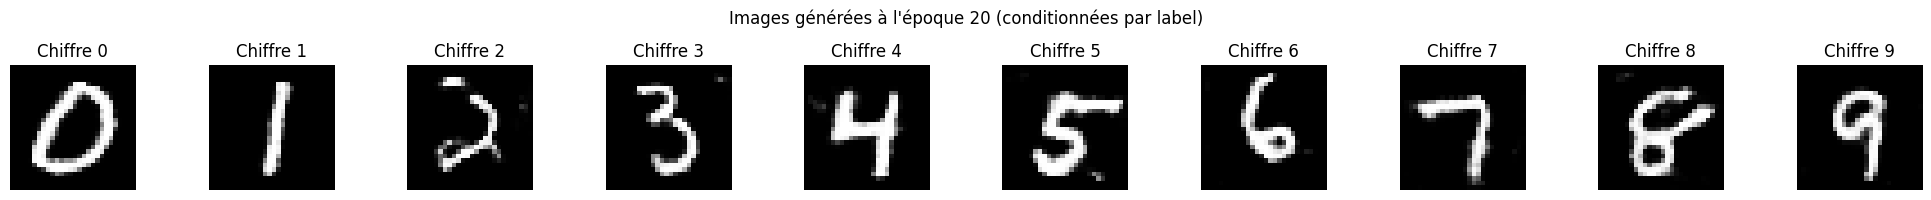

Epoch 30/50 - D loss: 0.6771, G loss: 0.7444


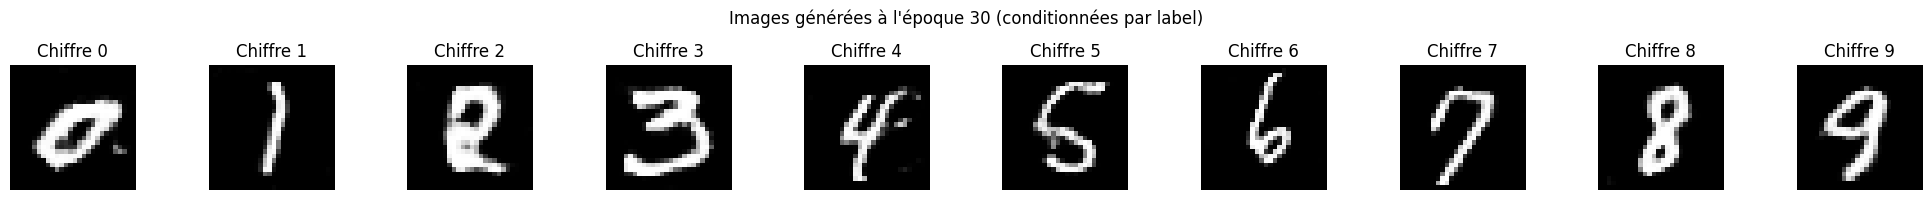

Epoch 40/50 - D loss: 0.6750, G loss: 0.7478


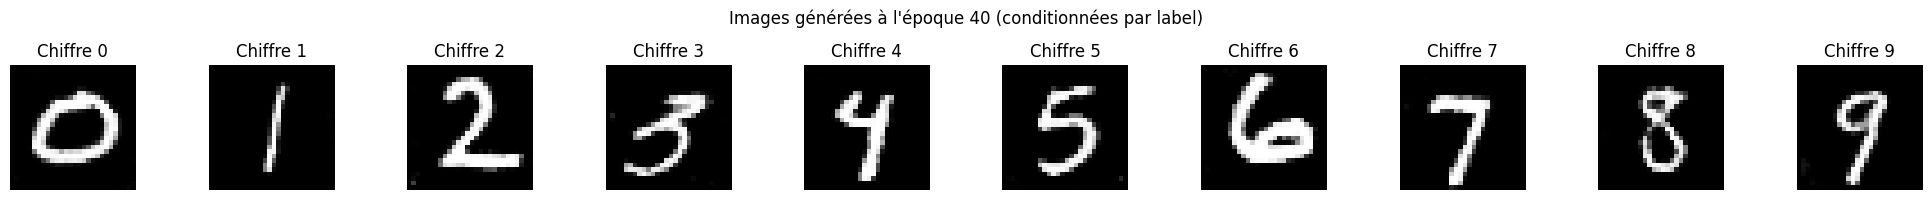

Epoch 50/50 - D loss: 0.6720, G loss: 0.7526


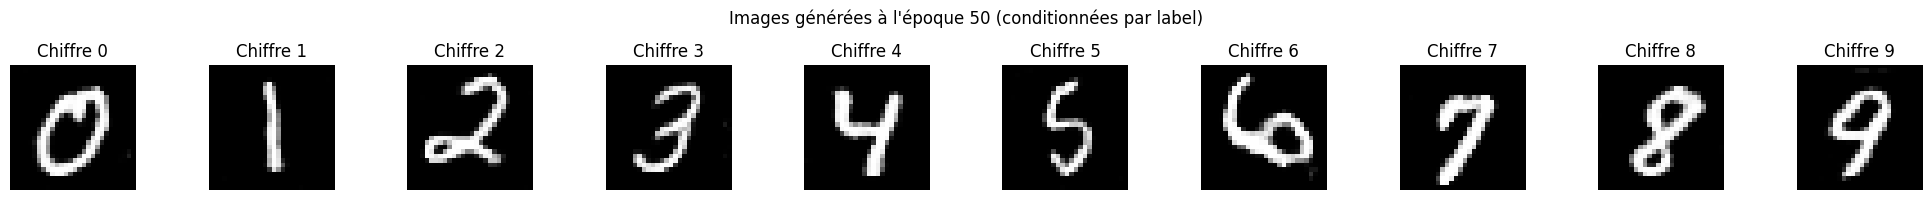

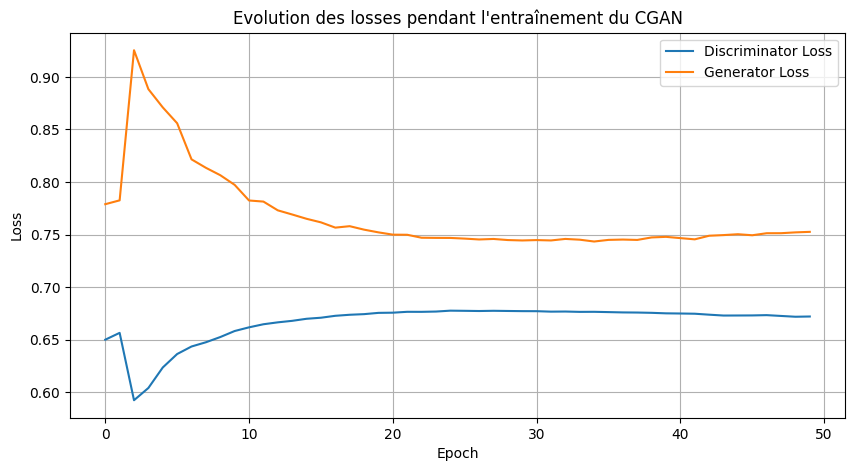


=== Génération de chiffres spécifiques ===


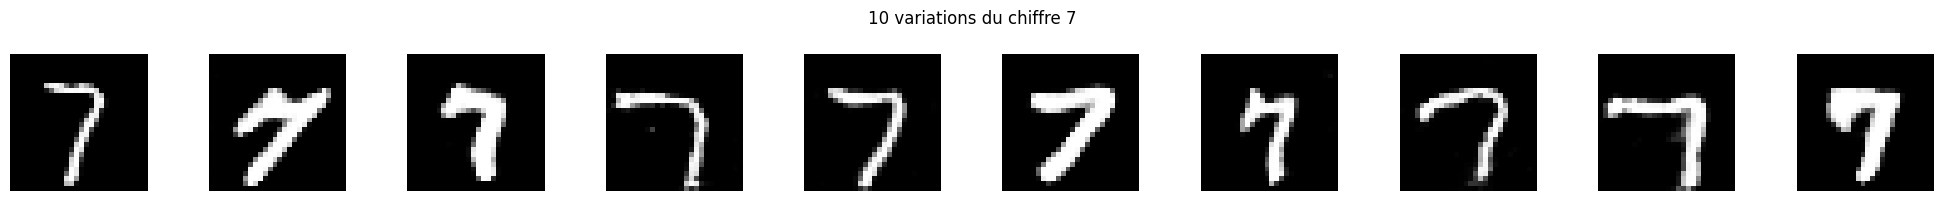


Modèles CGAN sauvegardés!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Configuration du device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation du device: {device}")

# Paramètres
latent_dim = 32
num_classes = 10  # Chiffres 0-9
img_shape = (1, 28, 28)
batch_size = 128
epochs = 50
lr = 0.0001
beta1 = 0.4

# Charger les données MNIST (on garde les labels cette fois !)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# ====== Générateur Conditionnel ======
class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()

        # Entrée : z (latent_dim) + c (num_classes) = 32 + 10 = 42
        input_dim = latent_dim + num_classes

        # Couche Dense qui transforme l'entrée en (14x14x128)
        self.fc = nn.Linear(input_dim, 14 * 14 * 128)

        self.model = nn.Sequential(
            # (14x14x128)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Conv2DTranspose (14x14x128 -> 14x14x128)
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Conv2DTranspose (14x14x128 -> 28x28x64)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Couche finale (28x28x1)
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Concaténer z et labels one-hot
        # z: [batch_size, latent_dim]
        # labels: [batch_size, num_classes]
        gen_input = torch.cat([z, labels], dim=1)  # [batch_size, latent_dim + num_classes]
        x = self.fc(gen_input)
        x = x.view(-1, 128, 14, 14)
        img = self.model(x)
        return img

# ====== Discriminateur Conditionnel ======
class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()

        # Embedding pour les labels : convertir le label en une "image" de labels
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        # Entrée : image (1 canal) + label_map (10 canaux) = 11 canaux
        self.model = nn.Sequential(
            # Entrée: (11, 28, 28) - image + label channels
            nn.Conv2d(1 + num_classes, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # (64, 14, 14)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # (128, 7, 7)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # (256, 3, 3)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # img: [batch_size, 1, 28, 28]
        # labels: [batch_size] (indices de classe)

        # Créer une "carte" de labels pour chaque image
        # On répète le one-hot encoding sur toute l'image
        batch_size = img.size(0)

        # Convertir les labels en one-hot
        labels_one_hot = torch.zeros(batch_size, num_classes).to(device)
        labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)

        # Répéter spatialement pour créer une "image" de labels (batch, 10, 28, 28)
        label_map = labels_one_hot.view(batch_size, num_classes, 1, 1)
        label_map = label_map.expand(batch_size, num_classes, 28, 28)

        # Concaténer l'image et les canaux de labels
        disc_input = torch.cat([img, label_map], dim=1)  # [batch_size, 11, 28, 28]

        features = self.model(disc_input)
        validity = self.fc(features)
        return validity

# Instancier les modèles
generator = ConditionalGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)

print("=== Architecture du Générateur Conditionnel ===")
print(generator)
print(f"\nNombre de paramètres: {sum(p.numel() for p in generator.parameters() if p.requires_grad)}")

print("\n=== Architecture du Discriminateur Conditionnel ===")
print(discriminator)
print(f"\nNombre de paramètres: {sum(p.numel() for p in discriminator.parameters() if p.requires_grad)}")

# Optimiseurs et fonction de perte
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# ====== Fonction pour convertir labels en one-hot ======
def to_one_hot(labels, num_classes=10):
    batch_size = labels.size(0)
    one_hot = torch.zeros(batch_size, num_classes).to(device)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

# ====== Apprentissage du CGAN ======
def train():
    generator_loss = []
    discriminator_loss = []

    for epoch in range(epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0

        for batch_idx, (real_images, real_labels) in enumerate(train_loader):
            current_batch_size = real_images.size(0)

            # Labels pour réel/faux
            labels_for_real_images = torch.ones(current_batch_size, 1).to(device)
            labels_for_fake_images = torch.zeros(current_batch_size, 1).to(device)

            real_images = real_images.to(device)
            real_labels = real_labels.to(device)

            # ====== Entraîner le Discriminateur ======
            optimizer_D.zero_grad()

            # 5. Tirage aléatoire du code latent
            input_noise = torch.randn(current_batch_size, latent_dim).to(device)

            # Tirage aléatoire des labels conditionnels (chiffres 0-9)
            fake_labels = torch.randint(0, num_classes, (current_batch_size,)).to(device)
            fake_labels_one_hot = to_one_hot(fake_labels)

            # 6. Générer des images conditionnées
            fake_image = generator(input_noise, fake_labels_one_hot).detach()

            # 7. Mélange d'images réelles et fausses avec leurs labels
            mixed_image = torch.cat([real_images, fake_image])
            mixed_condition_labels = torch.cat([real_labels, fake_labels])
            mixed_labels = torch.cat([labels_for_real_images, labels_for_fake_images])

            # 8. Entraîner le discriminateur conditionnel
            output = discriminator(mixed_image, mixed_condition_labels)
            d_loss = criterion(output, mixed_labels)
            d_loss.backward()
            optimizer_D.step()

            # ====== Entraîner le Générateur ======
            # 9. Nouveau tirage aléatoire
            input_noise = torch.randn(current_batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, num_classes, (current_batch_size,)).to(device)
            gen_labels_one_hot = to_one_hot(gen_labels)

            # 10. Entraîner le générateur
            optimizer_G.zero_grad()
            fake_images = generator(input_noise, gen_labels_one_hot)
            output = discriminator(fake_images, gen_labels)
            g_loss = criterion(output, labels_for_real_images)
            g_loss.backward()
            optimizer_G.step()

            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()

        # Moyenne des losses
        avg_d_loss = epoch_d_loss / len(train_loader)
        avg_g_loss = epoch_g_loss / len(train_loader)
        discriminator_loss.append(avg_d_loss)
        generator_loss.append(avg_g_loss)

        # Affichage toutes les 10 époques
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - D loss: {avg_d_loss:.4f}, G loss: {avg_g_loss:.4f}")

            # Générer des images pour chaque chiffre (0-9)
            generator.eval()
            with torch.no_grad():
                # Créer un bruit pour chaque chiffre
                noise = torch.randn(10, latent_dim).to(device)
                # Créer les labels 0, 1, 2, ..., 9
                sample_labels = torch.arange(0, 10).to(device)
                sample_labels_one_hot = to_one_hot(sample_labels)

                generated_imgs = generator(noise, sample_labels_one_hot).cpu()
                generated_imgs = (generated_imgs + 1) / 2  # Dénormaliser

            fig, axes = plt.subplots(1, 10, figsize=(20, 2))
            for i in range(10):
                axes[i].imshow(generated_imgs[i, 0], cmap='gray')
                axes[i].set_title(f'Chiffre {i}')
                axes[i].axis('off')
            plt.suptitle(f'Images générées à l\'époque {epoch + 1} (conditionnées par label)')
            plt.tight_layout()
            plt.show()

            generator.train()

    # Tracer l'évolution des losses
    plt.figure(figsize=(10, 5))
    plt.plot(discriminator_loss, label='Discriminator Loss')
    plt.plot(generator_loss, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Evolution des losses pendant l\'entraînement du CGAN')
    plt.grid(True)
    plt.show()

# Lancer l'apprentissage
print("\n=== Début de l'entraînement du CGAN ===")
train()

# ====== Fonction pour générer des chiffres spécifiques ======
def generate_specific_digits(digit, num_samples=10):
    """Génère plusieurs exemples d'un chiffre spécifique"""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim).to(device)
        labels = torch.full((num_samples,), digit, dtype=torch.long).to(device)
        labels_one_hot = to_one_hot(labels)

        generated_imgs = generator(noise, labels_one_hot).cpu()
        generated_imgs = (generated_imgs + 1) / 2

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
    for i in range(num_samples):
        axes[i].imshow(generated_imgs[i, 0], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f'10 variations du chiffre {digit}')
    plt.tight_layout()
    plt.show()

# Exemple : générer 10 versions différentes du chiffre 7
print("\n=== Génération de chiffres spécifiques ===")
generate_specific_digits(7, num_samples=10)

# Sauvegarder les modèles
torch.save(generator.state_dict(), 'cgan_generator.pth')
torch.save(discriminator.state_dict(), 'cgan_discriminator.pth')
print("\nModèles CGAN sauvegardés!")

False
[]
